In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
from sklearn.linear_model import Ridge, Lasso, LassoCV, LassoLarsCV, LinearRegression, BayesianRidge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
# import statsmodels.api as sm
# from patsy import dmatrix

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_100000_seed_3.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

# Scatter plots of all the input variables with Max_Proton_Energy(MeV)

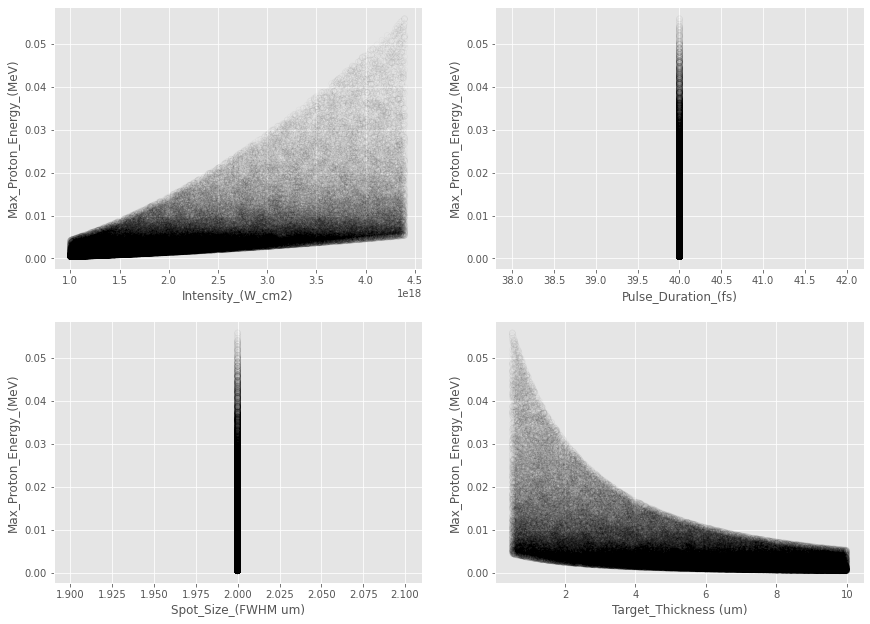

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(physics[inputs[0]],physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 0].set(xlabel=f'{inputs[0]}', ylabel=f'{outputs[0]}')

axs[0, 1].scatter(physics[inputs[1]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 1].set(xlabel=f'{inputs[1]}', ylabel=f'{outputs[0]}')

axs[1, 0].scatter(physics[inputs[2]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 0].set(xlabel=f'{inputs[2]}', ylabel=f'{outputs[0]}')

axs[1, 1].scatter(physics[inputs[3]], physics[outputs[0]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 1].set(xlabel=f'{inputs[3]}', ylabel=f'{outputs[0]}')

plt.subplots_adjust(bottom=1, right=2, top=3)

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df1. 

In [6]:
df1 = physics.copy()
df1 = df1.drop(columns=outputs[1:])
df1.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The train and split sets will also be created here for df1.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df1[inputs], df1[outputs[0]], test_size=0.33, random_state=0)

# Now we will create spline models for the max proton energy against intensity, and max proton energy against target thickness scatter plots

This is for max proton energy against intensity. We are also checking the time it took to create, train, and predict with the model.

In [8]:
start_time = time.process_time()

In [9]:
spline_mpe_intensity_variable = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=2))
spline_mpe_intensity_variable.fit(X_train[inputs[0]].values.reshape(-1, 1), y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=2))])

In [10]:
y_mpe_int_var_model = spline_mpe_intensity_variable.predict(X_train[inputs[0]].values.reshape(-1, 1))

In [11]:
end_time = time.process_time()

In [12]:
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.2610859999999997 seconds.


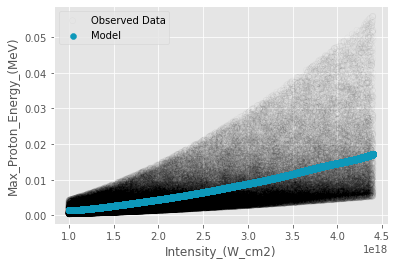

In [13]:
plt.scatter(physics[inputs[0]], physics[outputs[0]], facecolor='none', edgecolor='k', alpha=.035, label='Observed Data')
plt.scatter(X_train[inputs[0]].values, y_mpe_int_var_model, c = '#0D98BA', label='Model')
plt.legend()
plt.xlabel(f'{inputs[0]}')
plt.ylabel(f'{outputs[0]}')
plt.show()

##### Here is the mean squared error of our model of Max Proton Energy against Intensity

In [14]:
mean_squared_error(y_test, spline_mpe_intensity_variable.predict(X_test[inputs[0]].values.reshape(-1, 1)))

3.0161499624147052e-05

##### Now we will do the same for max proton energy against target thickness

In [15]:
start_time = time.process_time()

In [16]:
spline_mpe_target_thickness_variable = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=2))
spline_mpe_target_thickness_variable.fit(X_train[inputs[3]].values.reshape(-1, 1), y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=2))])

In [17]:
y_mpe_t_var_model = spline_mpe_target_thickness_variable.predict(X_train[inputs[3]].values.reshape(-1, 1))

In [18]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.36829 seconds.


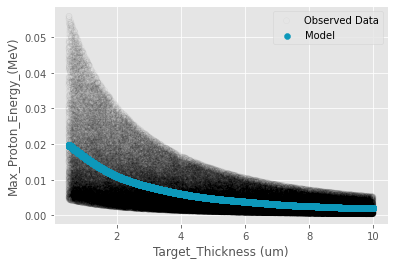

In [19]:
plt.scatter(physics[inputs[3]], physics[outputs[0]], facecolor='none', edgecolor='k', alpha=.035, label='Observed Data')
plt.scatter(X_train[inputs[3]].values, y_mpe_t_var_model, c = '#0D98BA', label='Model')
plt.legend()
plt.xlabel(f'{inputs[3]}')
plt.ylabel(f'{outputs[0]}')
plt.show()

##### Here is the mean squared error of our model of Max Proton Energy against target thickness

In [20]:
mean_squared_error(y_test, spline_mpe_target_thickness_variable.predict(X_test[inputs[3]].values.reshape(-1, 1)))

2.959515053216144e-05

##### Out of curiosity, here is a model that uses all four of our input variables. This will be investigated further on.

In [21]:
model = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=.001))
model.fit(X_train, y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=0.001))])

In [22]:
mean_squared_error(y_test, model.predict(X_test))

1.013196625021021e-05

### Now we will create error plots for target thickness and intensity with max proton energy.

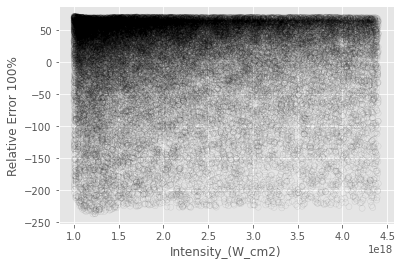

In [23]:
y_mpe_int_var_pred = spline_mpe_intensity_variable.predict(X_test[inputs[0]].values.reshape(-1, 1))
plt.scatter(X_test[inputs[0]].values,
            ((y_mpe_int_var_pred - y_test) / y_mpe_int_var_pred) * 100,
            facecolor='none',
            edgecolor='k',
            alpha=.1)
plt.xlabel(f'{inputs[0]}')
plt.ylabel('Relative Error 100%')
plt.show()

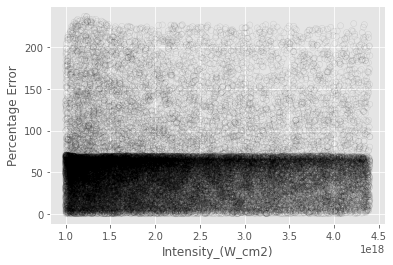

In [24]:
y_mpe_int_var_pred = spline_mpe_intensity_variable.predict(X_test[inputs[0]].values.reshape(-1, 1))
plt.scatter(X_test[inputs[0]].values,
            (np.abs((y_mpe_int_var_pred - y_test) / y_mpe_int_var_pred)) * 100,
            facecolor='none',
            edgecolor='k',
            alpha=.1)
plt.xlabel(f'{inputs[0]}')
plt.ylabel('Percentage Error')
plt.show()

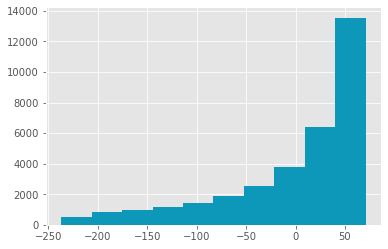

In [25]:
plt.hist(((y_mpe_int_var_pred - y_test) / y_mpe_int_var_pred) * 100, color='#0D98BA')
plt.show()

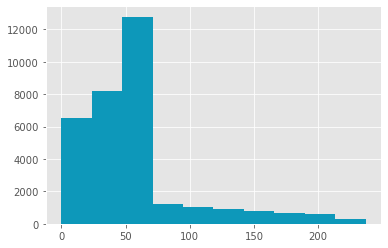

In [26]:
plt.hist(np.abs((y_mpe_int_var_pred - y_test) / y_mpe_int_var_pred) * 100, color='#0D98BA')
plt.show()

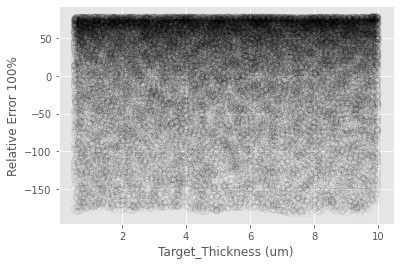

In [27]:
y_mpe_t_var_pred = spline_mpe_target_thickness_variable.predict(X_test[inputs[3]].values.reshape(-1, 1))
plt.scatter(X_test[inputs[3]].values,
            ((y_mpe_t_var_pred - y_test) / y_mpe_t_var_pred) * 100,
            facecolor='none',
            edgecolor='k',
            alpha=.1)
plt.xlabel(f'{inputs[3]}')
plt.ylabel('Relative Error 100%')
plt.show()

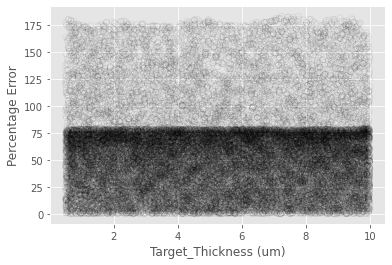

In [28]:
y_mpe_t_var_pred = spline_mpe_target_thickness_variable.predict(X_test[inputs[3]].values.reshape(-1, 1))
plt.scatter(X_test[inputs[3]].values,
            (np.abs((y_mpe_t_var_pred - y_test) / y_mpe_t_var_pred)) * 100,
            facecolor='none',
            edgecolor='k',
            alpha=.1)
plt.xlabel(f'{inputs[3]}')
plt.ylabel('Percentage Error')
plt.show()

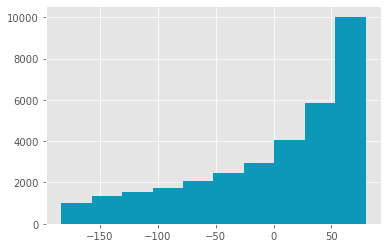

In [29]:
plt.hist(((y_mpe_t_var_pred - y_test) / y_mpe_t_var_pred) * 100, color='#0D98BA')
plt.show()

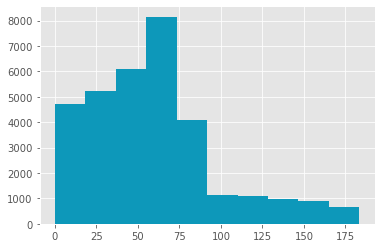

In [30]:
plt.hist(np.abs((y_mpe_t_var_pred - y_test) / y_mpe_t_var_pred) * 100, color='#0D98BA')
plt.show()

# Now we will create a model with max proton energy as the output. The inputs will be target thickness and intensity.

##### The colors in the following scatter plot are only to give the plot a 3d feel. The colors are not meant to indicate the value of a fourth variable.

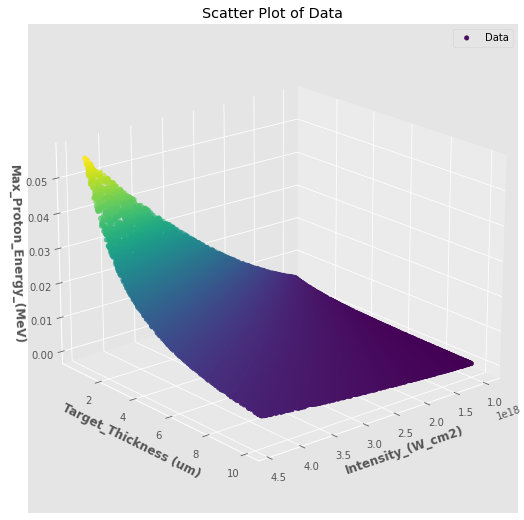

In [31]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = y_train / (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

##### This creates a model with the out variable max proton energy against both input variables target thickness ans intensity.

In [32]:
start_time = time.process_time()

In [33]:
spline_mpe_int_tt_var = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=.001))

In [34]:
spline_mpe_int_tt_var.fit(X_train[[inputs[0], inputs[3]]], y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=0.001))])

In [35]:
print(f'The MSE of the testing set is {mean_squared_error(y_test,spline_mpe_int_tt_var.predict(X_test[[inputs[0], inputs[3]]]))}.')

The MSE of the testing set is 1.013196625021021e-05.


In [36]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.22170300000000154 seconds.


In [37]:
y_mpe_int_tt_var_model_var = spline_mpe_int_tt_var.predict(X_train[[inputs[0], inputs[3]]])

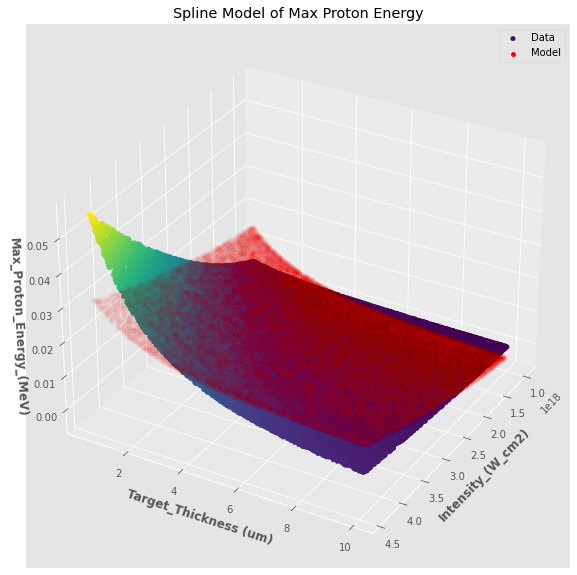

In [38]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = y_train/ (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_mpe_int_tt_var_model_var,
           c = 'red',
           alpha= .015,
           label= 'Model')
ax.set_title('Spline Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(30, 30)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
plt.show()

In [39]:
error_series = np.abs((y_test - spline_mpe_int_tt_var.predict(X_test[[inputs[0], inputs[3]]])) / y_test)
error_3d = X_test[[inputs[0], inputs[3]]].copy()
error_3d['Relative Error'] = error_series

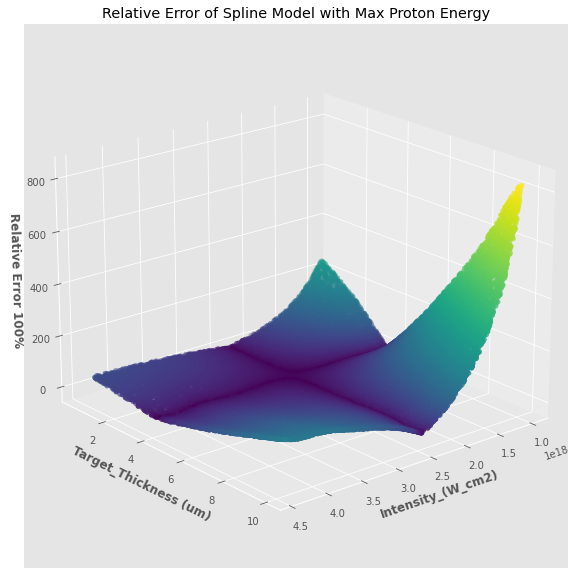

In [40]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d['Relative Error'] * 100,
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of Spline Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error 100%', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

##### This time a model will be created with log(max proton energy) instead of just max proton energy, still with the same input variables.

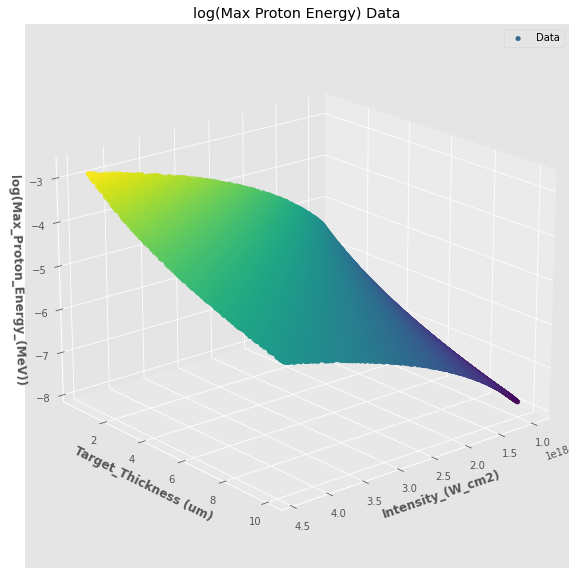

In [41]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c = np.log(y_train),
           label= 'Data')
ax.set_title('log(Max Proton Energy) Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'log({outputs[0]})', fontweight ='bold')
ax.view_init(20, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

In [42]:
start_time = time.process_time()

##### Creating the log spline model.

In [43]:
spline_mpe_int_tt_var_log = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=.001))

In [44]:
spline_mpe_int_tt_var_log.fit(X_train[[inputs[0], inputs[3]]], np.log(y_train))

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=0.001))])

In [45]:
y_mpe_int_tt_var_model_var_log = spline_mpe_int_tt_var_log.predict(X_train[[inputs[0], inputs[3]]])

##### CPU time to run, train, and predict data

In [46]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.2765529999999998 seconds.


##### Mean squared error of the log spline model

In [47]:
mean_squared_error(np.log(y_test),
                   spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])
                   )

1.2573307698913297e-06

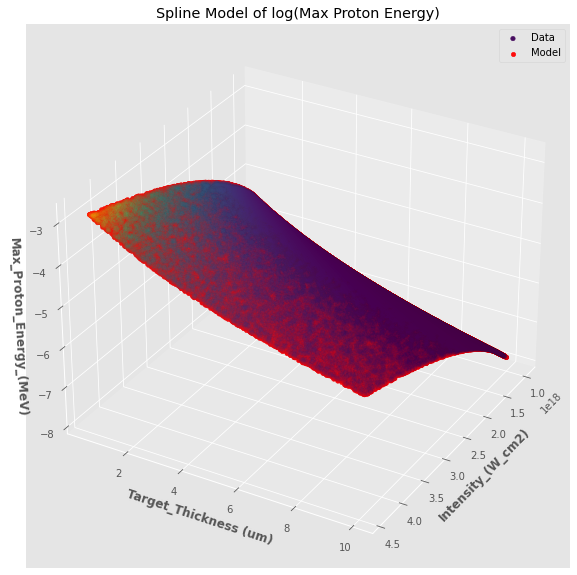

In [48]:
fig4 = plt.figure(figsize=(10, 10))
ax = fig4.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c = y_train/ (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           alpha= .05,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_mpe_int_tt_var_model_var_log,
           c = 'red',
           alpha= .95,
           label= 'Model')
ax.set_title('Spline Model of log(Max Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(30, 30)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

In [49]:
error_series_log = np.abs((np.log(y_test) - spline_mpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])) / np.log(y_test))
error_3d_log = X_test[[inputs[0], inputs[3]]].copy()
error_3d_log['Relative Error'] = error_series_log

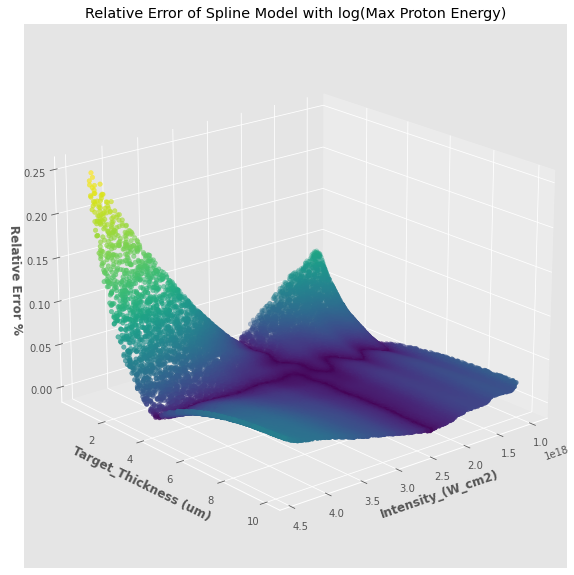

In [50]:
fig6 = plt.figure(figsize=(10, 10))
ax = fig6.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['Relative Error'] * 100,
           c = np.sqrt(error_3d_log['Relative Error']))
ax.set_title('Relative Error of Spline Model with log(Max Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

# Spline model to predict total energy protons

##### Scatter plot of total energy protons with the input variables.

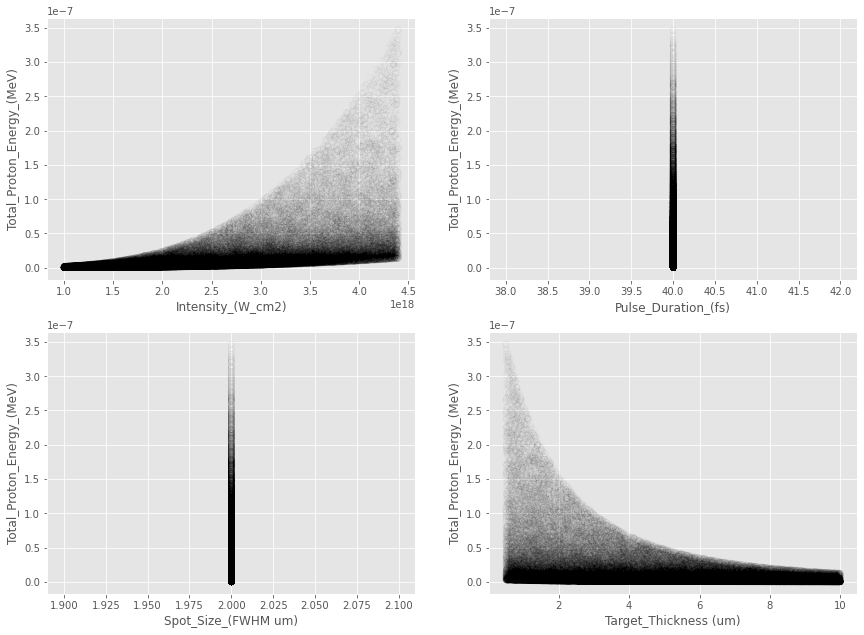

In [51]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(physics[inputs[0]],physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 0].set(xlabel=f'{inputs[0]}', ylabel=f'{outputs[1]}')

axs[0, 1].scatter(physics[inputs[1]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 1].set(xlabel=f'{inputs[1]}', ylabel=f'{outputs[1]}')

axs[1, 0].scatter(physics[inputs[2]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 0].set(xlabel=f'{inputs[2]}', ylabel=f'{outputs[1]}')

axs[1, 1].scatter(physics[inputs[3]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 1].set(xlabel=f'{inputs[3]}', ylabel=f'{outputs[1]}')

plt.subplots_adjust(bottom=1, right=2, top=3)

##### creating new dataframe with total energy protons as the only output variable.

In [52]:
df2 = physics.copy()
df2.drop(outputs[0], axis= 1, inplace= True)
df2.drop(outputs[2], axis= 1, inplace= True)

##### Creating the training and testing data sets.

In [53]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2[inputs], df2[outputs[1]], test_size=0.33, random_state=0)

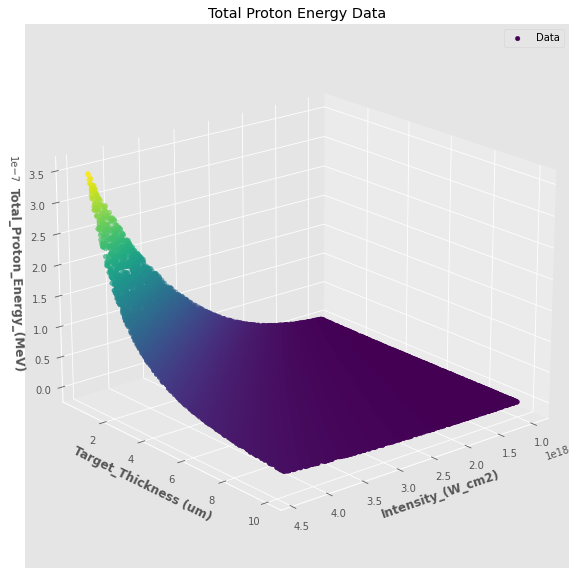

In [54]:
fig7 = plt.figure(figsize=(10, 10))
ax = fig7.add_subplot(projection='3d')
ax.scatter(X_train_2[inputs[0]],
           X_train_2[inputs[3]],
           y_train_2,
           c = y_train_2,
           label= 'Data')
ax.set_title('Total Proton Energy Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[1]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### The following is a scatter plot of log(total proton energy).

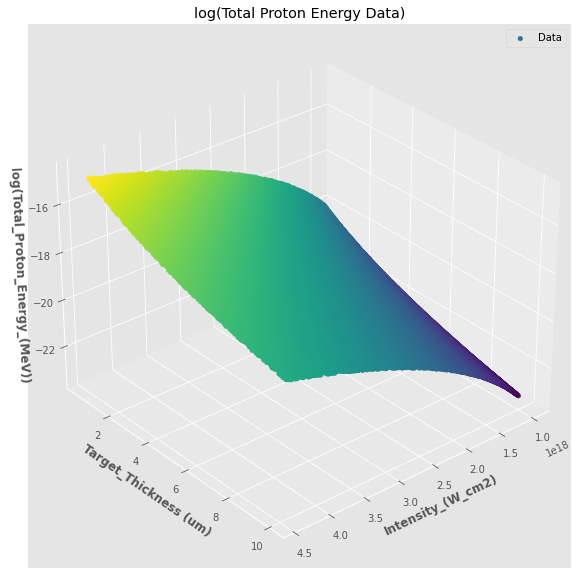

In [55]:
fig7 = plt.figure(figsize=(10, 10))
ax = fig7.add_subplot(projection='3d')
ax.scatter(X_train_2[inputs[0]],
           X_train_2[inputs[3]],
           np.log(y_train_2),
           c = np.log(y_train_2),
           label= 'Data')
ax.set_title('log(Total Proton Energy Data)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'log({outputs[1]})', fontweight ='bold')
ax.view_init(30, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Creating the log spline model for total proton energy.

In [56]:
start_time = time.process_time()

In [57]:
spline_tpe_int_tt_var_log = make_pipeline(SplineTransformer(n_knots=8, degree=3), Ridge(alpha=.001))

In [58]:
spline_tpe_int_tt_var_log.fit(X_train_2[[inputs[0], inputs[3]]], np.log(y_train_2))

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridge', Ridge(alpha=0.001))])

In [59]:
y_tpe_int_tt_var_model_var_log = spline_tpe_int_tt_var_log.predict(X_train_2[[inputs[0], inputs[3]]])

##### CPU time for spline log model for total proton energy.

In [60]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.30864700000000056 seconds.
